In [1]:
import cPickle as pickle
from  PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from collections import defaultdict
from tqdm import tqdm

# get imgs for each class
f = open('/Users/fangtiantian/Documents/research/normalization/data/cifar-10-batches-py/data_batch_1', 'rb')

tupled_data= pickle.load(f)
f.close()
labels = tupled_data['labels']
img = tupled_data[b'data']


selected_imgs = []
selected_lables = []

for la in range(10):
    ind = labels.index(la)
    single_img = img[ind]
    single_img = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
    selected_imgs.append(single_img)
    selected_lables.append(labels[ind])

# print selected_lables

fig=plt.figure(figsize=(10, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = selected_imgs[i-1]
    plt.imshow(img)
plt.show()

<Figure size 1000x400 with 10 Axes>

In [2]:
def quantize(raster, n_colors=32):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))

    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_.astype(int)
    quantized_raster = np.reshape(
        palette[labels], (width, height, palette.shape[1]))
    return quantized_raster, palette

def add_noise(clus_img, colors_palette):
    noise_img = clus_img
    (h, w, _) = clus_img.shape
    for i in range(h):
        for j in range(w):
            p = bernoulli.rvs(1./32)
            if p == 1:
                # uniformly choose a color as noise
                noise_img[i,j] = colors_palette[np.random.randint(32)]
    return noise_img

In [11]:
sigma  = 0.1  #noise level
J = 1  #coupling strength (w_ij)
rate = 0.5  #update smoothing rate
max_iter = 3

In [5]:
def denoise_image(data, colors_palette):
    img = np.double(data) / 255.
    img_mean = np.mean(img)
    [M, N, d] = img.shape
    y = img

    log_L = []
    for i in range(32):
        log_L.append(multivariate_normal.logpdf(y.reshape([-1, 3]), mean=colors_palette[i], cov=sigma**2))
    log_L = np.array(log_L)
    denomiator = np.sum(np.exp(log_L), axis=0)
    q = np.exp(log_L) / denomiator

    # mu = E_{q_i(x_k)}[x_k]
    mu = np.transpose(q).dot(colors_palette)
    a = colors_palette.dot(np.transpose(mu)) + log_L  # a: [32, 1024]
    mu = mu.reshape((M, N, 3))
    a = a.astype(np.int)
    
    # iter
    for i in tqdm(range(max_iter)):
        muNew = mu
        for ix in range(N):
            for iy in range(M):
                pos = iy + M * ix
                neighborhood = pos + np.array([-1, 1, -M, M])            
                boundary_idx = [iy != 0, iy != M - 1, ix != 0, ix != N - 1]
                neighborhood = neighborhood[np.where(boundary_idx)[0]]            
                xx, yy = np.unravel_index(pos, (M,N), order='F')
                nx, ny = np.unravel_index(neighborhood, (M,N), order='F')

                # 周围邻居和自己 改了改 也不知道对不对。。
                neigh = np.zeros((32, 1))
                cur_N = np.zeros((32, 1))
                for k in range(32):
                    cur_N[k] += multivariate_normal.logpdf(muNew[xx, yy], mean=colors_palette[k], cov=sigma**2)
                    for dd in range(nx.shape[0]):
                        neigh[k] += multivariate_normal.logpdf(muNew[nx[dd], ny[dd]], mean=colors_palette[k], cov=sigma**2)

                update_part_1 = neigh + cur_N 
                cur_update_prob = np.exp(update_part_1) / np.sum(np.exp(update_part_1))
                cur_update = colors_palette[np.argmax(cur_update_prob)]

                muNew[xx, yy] = (1 - rate) * muNew[xx, yy, :] + rate * cur_update
        mu = muNew
    return mu

100%|██████████| 3/3 [00:56<00:00, 18.60s/it]


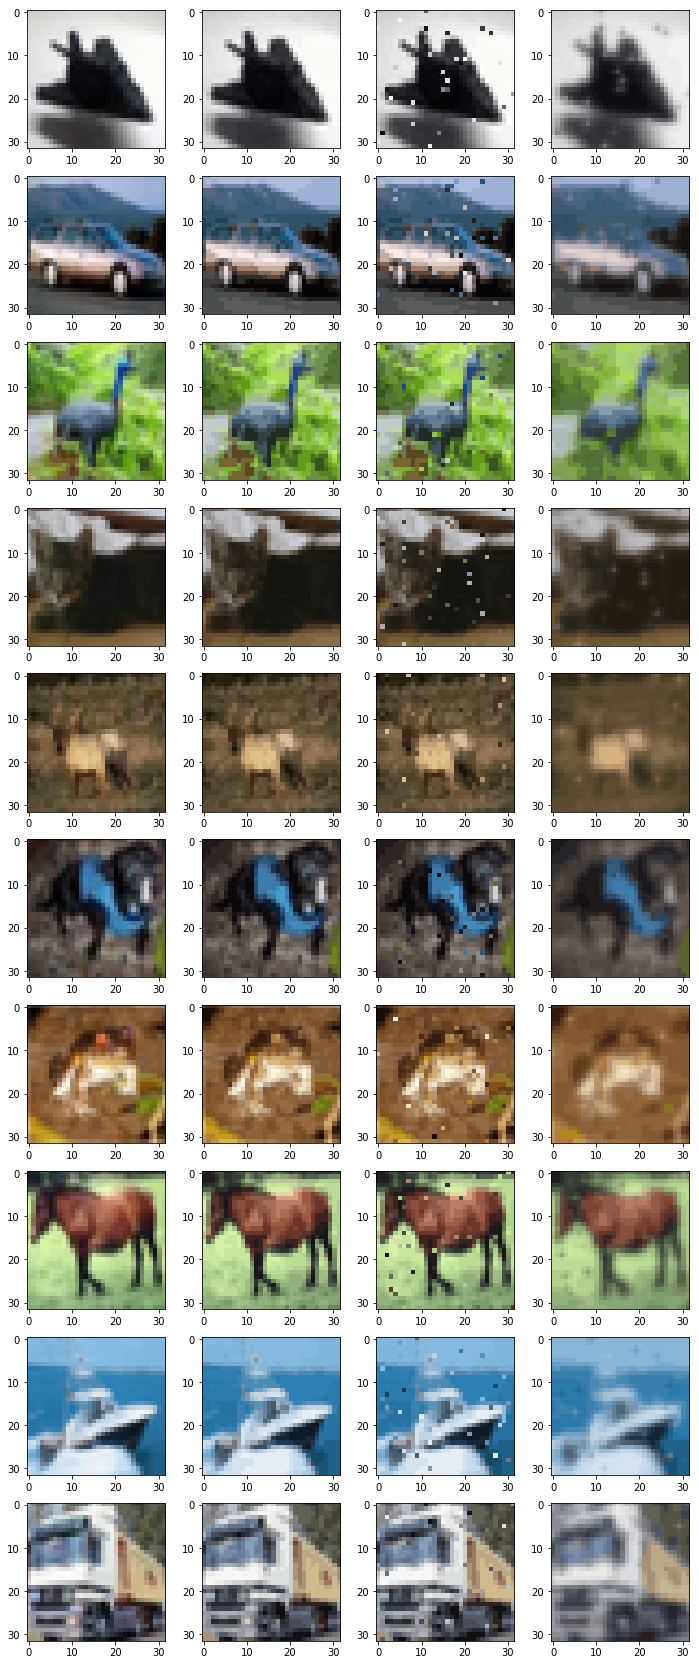

In [12]:
fig=plt.figure(figsize=(12, 30))
columns = 4
rows = 10


for i, im in enumerate(selected_imgs):
    # plot original img
    fig.add_subplot(rows, columns, i*4+1)
    plt.imshow(im)
    
    # plot clustered img
    clus_img, colors_palette = quantize(im)
    fig.add_subplot(rows, columns, i*4+2)
    plt.imshow(clus_img)
    
    #add noise and plot
    noise_img = add_noise(clus_img, colors_palette)
    fig.add_subplot(rows, columns, i*4+3)
    plt.imshow(noise_img)
    
    # denoise and plot
    clean_img = denoise_image(noise_img, colors_palette / 255.)
    fig.add_subplot(rows, columns, i*4+4)
    plt.imshow(clean_img)
    
plt.show()


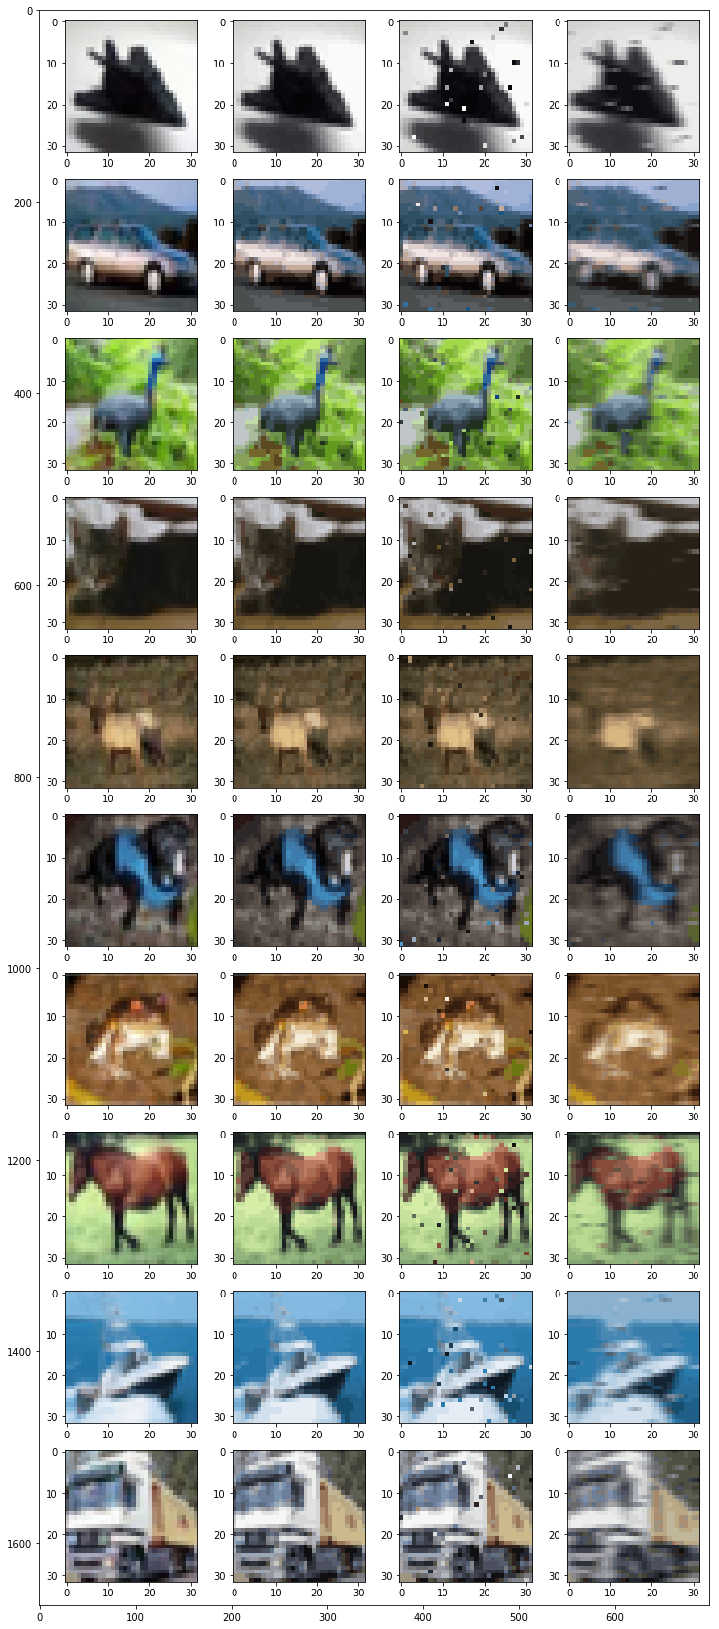

In [4]:
result = Image.open('MeanField.png')
result = np.asarray(result)
fig=plt.figure(figsize=(12, 30))
plt.imshow(result)